Import the librairies and modules:

In [1]:
import networkx as nx
import os
import csv
import re
import numpy as np
import concurrent.futures
from pathlib import Path
from joblib import Parallel, delayed
from BAG_Code_tw520.BayesianAttackGraphForCVSS import parse_dot
from Threat_Inteligence.CWE_tree.parse import parse_xml
from BAG_Code_tw520.BayesianAttackGraphForCVSS import change_prob
from BAG_Code_tw520.createANDtable import create_AND_table
from BAG_Code_tw520.createORtable import create_OR_table

from pgmpy.inference.ExactInference import BeliefPropagation
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

To prepare the simulation use the following to put the graph in memory:

In [2]:
MAX = 0.999

def parse_dot(dot_string):
    nodes = {}
    edges = []

    # Définir une expression régulière pour extraire les informations de chaque nœud
    # node_pattern = re.compile("(\d+)")
    node_pattern = re.compile(r'\s+(\d+)\s+\[\s*label="([^"]+)"\s+shape="([^"]+)"\s+CVE="([^"]+)"\s*\];')

    # Définir une expression régulière pour extraire les arêtes
    edge_pattern = re.compile(r'\s+(\d+)\s*->\s*(\d+)\s+\[\s+color="[^"]+"\s*\];')

    # Parcourir chaque ligne du texte
    for line in dot_string.split('\n'):
        # Vérifier si la ligne correspond à un nœud
        node_match = node_pattern.match(line)
        # Vérifier si la ligne correspond à une arête
        edge_match = edge_pattern.match(line)
        if node_match:
            node_id = int(node_match.group(1))
            label = node_match.group(2)
            shape = node_match.group(3)
            node_type = 'AND' if shape == "ellipse" else 'OR'
            cveID = node_match.group(4).strip("\'")
            nodes[node_id] = {'label': label, 'type': node_type, 'CVE': cveID, 'shape': shape}
        elif edge_match:
            source = int(edge_match.group(1))
            target = int(edge_match.group(2))
            edges.append((source, target))
    model = BayesianNetwork(edges)
    # Read the probabilities for each CVE
    cvss_dict = {}
    with open('./Threat_Inteligence/epss_scores-2024-04-25.csv', mode='r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            cvss_dict[row['cve']] = row['epss']
    for elem in nodes.items():
        r = elem[1]['type'] == 'OR'
        #We look for the source nodes
        source = []
        probs = []
        for edge in edges:
            if edge[1] == elem[0]:
                source.append(edge[0])
                if elem[1]['CVE'] in cvss_dict.keys():
                    probs.append(float(cvss_dict[elem[1]['CVE']]))
                else:
                    # We use the probability associated to the rule if not null
                    tmp = float(nodes[edge[0]]['label'].split(':')[2])
                    if tmp != 0:
                        print(elem[1]['label'])
                        probs.append(float(tmp))
                    else: 
                        probs.append(MAX)
        npa = len(source)
        #We draw the probability from the distribution of CVSS scores
        if r:
            cpt = create_OR_table(probs)
        else:
            cpt = create_AND_table(probs)
        if npa:
            cpd = TabularCPD(elem[0], 2, cpt.T, source, evidence_card=2*np.ones(npa))
        else:
            cpd = TabularCPD(elem[0], 2, cpt.T)
        #Insert the conditional probability table into the Bayesian Network object
        model.add_cpds(cpd)
    return model, edges, nodes


def change_prob(BAG, edges, nodes, cwe_dict, Gcwe, prop0, factor, evidence_loc):
    src_node = set()
    for c_node in evidence_loc:
        src_node.update(get_all_ancestors(BAG, c_node))
    dst_node = set(nodes) - src_node
    for dst_n in dst_node:
        dst_k = dst_n
        dst_cve = nodes[dst_k]['CVE']
        if dst_cve == "null":
            continue
        print(dst_cve)
        dst_cwe = cwe_dict[dst_cve]
        if dst_cwe != 'NVD-CWE-Other' and dst_cwe != "NVD-CWE-noinfo":
            for e in edges:
                if e[1] == dst_k:
                    source = [e[0]]
                    new_prob = BAG.get_cpds(dst_k).values[1][1]
                    for s in src_node:
                        src_k = s
                        src_cve = nodes[src_k]['CVE']
                        if src_cve == "null":
                            continue
                        src_cwe = cwe_dict[src_cve]
                        if src_cwe != 'NVD-CWE-Other' and src_cwe != "NVD-CWE-noinfo":
                            dist = nx.shortest_path_length(Gcwe, source=src_cwe.split('-')[1], target=dst_cwe.split('-')[1])
                            print("CVE source : " + nodes[src_k]['label'])
                            tmp_prob = factor**(dist+1) * prop0.query([src_k],evidence=evidence_loc).values[1]
                            print(222222222222222222222222222222)
                            new_prob = tmp_prob + new_prob - new_prob*tmp_prob
                    props = create_OR_table([new_prob])
                    BAG.remove_cpds(dst_k)
                    BAG.add_cpds(TabularCPD(dst_k, 2, props.T, source, evidence_card=2*np.ones(1)))

def get_all_ancestors(BAG, node, ancestors=set()):
    parents = BAG.get_parents(node)
    ancestors.update(parents)
    for p in parents:
        get_all_ancestors(BAG, p, ancestors)
    return ancestors

def to_dot(BAG, nodes, evidences, display_kts=False):
    dot = 'digraph G {\n'
    regex = r"\d+:RULE \d+ \((.*?)\):\d+\.\d+"
    print(BAG)
    prop = BeliefPropagation(BAG)
    nodes_wo_evidences = [n for n in nodes.keys() if n not in evidences.keys()]
    total_prob = prop.query(nodes_wo_evidences, evidence=evidences)
    def node_to_dot(node):
        if node not in evidences.keys():
            prob = total_prob.marginalize([n for n in nodes_wo_evidences if n != node], inplace=False).values[1]
        else:
            prob = 1
        probH = int(prob * 255)
        color = '#' + format(probH, '02X') +''+ format(255-probH, '02X') + '00'
        CVE = nodes[node]['CVE']
        LABEL = nodes[node]['label']
        number = LABEL.split(":")[0]
        prob = "{:.3f}".format(prob)
        shape = nodes[node]['shape']
        if CVE != 'null':
            return f'  {node} [label=\"{node} ({number})\\n{CVE}\\n{prob}\", color=\"{color}\", penwidth=3, shape=\"{shape}\"];\n'
        else:
            correspondance = re.search(regex, LABEL)
            if correspondance:
                return f'  {node} [label=\"{node} ({number})\\n{correspondance.group(1)}\\n{prob}\", color=\"{color}\", penwidth=3, shape=\"{shape}\"];\n'
            else:
                return f'  {node} [label="{node} ({number})\\n{LABEL}\\n{prob}", color="{color}", penwidth=3, shape="{shape}"];\n'
    for node in nodes.keys():
        dot += node_to_dot(node)
    for edge in BAG.edges():
        if display_kts or edge[0] in nodes.keys():
            dot += f'  \"{edge[0]}\" -> \"{edge[1]}\";\n'
    dot += '}'
    return dot



In [3]:
# Name of the simulation
simulation = "selection_pour présentation"

# Constante for probability one 
MAX = 0.999

# Path to the folder containing the tree
# path = os.path.join(os.getcwd(), "/ImperialWork/Personnal_simulations/output_" + simulation + "/strongly_connected_components/")
path = Path.cwd() / ("Personnal_simulations/output_" + simulation + "/strongly_connected_components/")
file_name = "ag-nocycles.dot"
path_to_dot = path / file_name
output_file = path / (file_name[:-4] + "_colored.dot")

# We all read from the file, adding probabilities in the same time
BAG, edges, nodes = parse_dot(open(path_to_dot, 'r').read())

# This is the reference BAG, before the attacker has compromised any node
BAG_ref = BAG.copy()
prop0 = BeliefPropagation(BAG_ref)

# We create a dictionary to get the node number from the label
inverted_nodes = {int(v['label'].split(':')[0]): k for k, v in nodes.items()}

1:admin(domain):0
[(0,), (1,)]
[[0.99 0.2 ]
 [0.   0.  ]]
[(0,), (1,)]
[(0, 0)]
c= []
q[c] = []
pop= [0.01]
[(0, 1)]
c= [0]
q[c] = [0.999]
pop= []
4:dcSync(domain):0
4:dcSync(domain):0
[(0, 0), (0, 1), (1, 0), (1, 1)]
[[0.99 0.2  0.2  0.04]
 [0.   0.   0.   0.  ]]
[(0,), (1,)]
[(0, 0)]
c= []
q[c] = []
pop= [0.01]
[(0, 1)]
c= [0]
q[c] = [0.999]
pop= []
7:passTheTicket(domain):0
[(0,), (1,)]
[[0.99 0.2 ]
 [0.   0.  ]]
[(0,), (1,)]
[(0, 0)]
c= []
q[c] = []
pop= [0.01]
[(0, 1)]
c= [0]
q[c] = [0.90761]
pop= []
10:validCredentials(domain):0
[(0,), (1,)]
[[0.99 0.2 ]
 [0.   0.  ]]
11:RULE 6 (valid credentials may be found):0.8
[(0,), (1,)]
[(0, 0)]
c= []
q[c] = []
pop= [0.01]
[(0, 1)]
c= [0]
q[c] = [1.]
pop= []
[(0,), (1,)]
[(0, 0)]
c= []
q[c] = []
pop= [0.01]
[(0, 1)]
c= [0]
q[c] = [0.0547]
pop= []
15:coerceSMB(domain):0
[(0,), (1,)]
[[0.99 0.2 ]
 [0.   0.  ]]
[(0,), (1,)]
[(0, 0)]
c= []
q[c] = []
pop= [0.01]
[(0, 1)]
c= [0]
q[c] = [0.90617]
pop= []
18:admin(host):0
18:admin(host):0
[(0, 0),

In [4]:
# The skills layer:
cpd_ALskills = TabularCPD('ALskills', 2, [[1-MAX], [MAX]])
cpd_AHskills = TabularCPD('AHskills', 2, [[MAX], [1-MAX]])
cpd_0skills = TabularCPD('uskills', 2, [[0.5], [0.5]])
BAG.add_edge('ALskills', 'Lskills')
BAG.add_edge('ALskills', 'Hskills')
BAG.add_edge('AHskills', 'Hskills')
BAG.add_edge('Hskills', 'Lskills')
cpd_Lskills = TabularCPD('Lskills', 2, create_OR_table([0.9, 1]).T, ['ALskills', 'Hskills'], evidence_card=2*np.ones(2))
cpd_Hskills = TabularCPD('Hskills', 2, create_OR_table([0.1, 0.9]).T, ['ALskills', 'AHskills'], evidence_card=2*np.ones(2))

# The tools layer:
cpd_Aimpacket = TabularCPD('Aimpacket', 2, [[0.5], [0.5]])
cpd_Aimpacketplus = TabularCPD('AimpacketP', 2, [[MAX], [1-MAX]])
BAG.add_edge('Aimpacket', 'impacketP')
BAG.add_edge('Aimpacket', 'impacket')
BAG.add_edge('AimpacketP', 'impacketP')
BAG.add_edge('impacketP', 'impacket')
cpd_impacket = TabularCPD('impacket', 2, create_OR_table([1, 1]).T, ['Aimpacket', 'impacketP'], evidence_card=2*np.ones(2))
cpd_impacketplus = TabularCPD('impacketP', 2, create_OR_table([0.9, 1]).T, ['Aimpacket', 'AimpacketP'], evidence_card=2*np.ones(2))
cpd_tools = [TabularCPD(tool, 2, [[0.5], [0.5]]) for tool in ['Metasploit', 'Responder', 'dnscmd.exe', 'certipy']]


# The knowledge layer:
cpd_knowledge = [TabularCPD(knowledge, 2, [[0.5], [0.5]]) for knowledge in ['Known vulnerabilities', 'CQCM', 'No credentials', 'MITM', 'Permissions move', 'Privilege escalation', 'Lateral move', 'ADCS']]

# Import all the dependencies
cpt_l4 = create_AND_table([MAX, MAX, MAX, MAX])
with open('./Threat_Inteligence/CVE_knowledge_tooling_skills.csv', mode='r') as ktsfile:
    reader = csv.DictReader(ktsfile)
    kts_dict = {}
    for row in reader:
        cve = row['Vulnerability']
        tmp = {'tool': row['tool'], 'skills': row['skills'], 'Type': row['Type']}
        kts_dict[cve] = tmp
for node in nodes.items():
        id = node[0]
        node = node[1]
        if node['CVE'] != "null":
            row = kts_dict[node['CVE']]
            if 'impacket' in row['tool'] and row['tool'] != 'impacket':
                name = 'impacket' + str(id)
                BAG.add_edge(name, id)
                BAG.add_edge('impacketP', name)
                BAG.add_cpds(TabularCPD(name, 2, create_OR_table([0.7]).T, ['impacketP'], evidence_card=2*np.ones(1)))
            elif row['tool'] == 'Unknown':
                print(row['tool'])
                name = 'unknown' + str(id)
                BAG.add_edge(name, id)
                BAG.add_cpds(TabularCPD(name, 2, [[0.5], [0.5]]))
            else:
                BAG.add_edge(row['tool'], id)
            BAG.add_edge(row['skills'] + 'skills', id)
            BAG.add_edge(row['Type'], id)
            parents = BAG.get_parents(id)
            BAG.add_cpds(TabularCPD(id, 2, cpt_l4.T, parents, evidence_card=2*np.ones(len(parents))))

# We add all the necessary CPDs to the BAG
for cpd in [cpd_0skills, cpd_impacketplus, cpd_Lskills, cpd_ALskills, cpd_AHskills, cpd_Hskills, cpd_Aimpacket, cpd_Aimpacketplus, cpd_impacket] + cpd_tools + cpd_knowledge:
    if BAG.__contains__(cpd.variable):
        BAG.add_cpds(cpd)

[(0, 0), (0, 1), (1, 0), (1, 1)]
[[0.99 0.   0.1  0.  ]
 [0.   0.   0.   0.  ]]
[(0, 0), (0, 1), (1, 0), (1, 1)]
[[0.99 0.1  0.9  0.09]
 [0.   0.   0.   0.  ]]
[(0, 0), (0, 1), (1, 0), (1, 1)]
[[0.99 0.   0.   0.  ]
 [0.   0.   0.   0.  ]]
[(0, 0), (0, 1), (1, 0), (1, 1)]
[[0.99 0.   0.1  0.  ]
 [0.   0.   0.   0.  ]]
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 1, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 1, 1, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1)]
[(0, 0), (1, 0), (2, 0), (3, 0)]
c= []
q[c] = []
pop= [0.01 0.01 0.01 0.01]
[(0, 0), (1, 0), (2, 0), (3, 1)]
c= [3]
q[c] = [0.999]
pop= [0.01 0.01 0.01]
[(0, 0), (1, 0), (2, 1), (3, 0)]
c= [2]
q[c] = [0.999]
pop= [0.01 0.01 0.01]
[(0, 0), (1, 0), (2, 1), (3, 1)]
c= [2, 3]
q[c] = [0.999 0.999]
pop= [0.01 0.01]
[(0, 0), (1, 1), (2, 0), (3, 0)]
c= [1]
q[c] = [0.999]
pop= [0.01 0.01 0.01]
[(0, 0), (1, 1), (2, 0), (3, 1)]
c= [1, 3]
q[c] = [0.999 0.999]
pop

In [5]:
evidence = {14 : 1}
with open(output_file, 'w') as f:
    f.write(to_dot(BAG, nodes, evidence, display_kts=True))
with open(path / ("BAG_ref" + ".dot"), 'w') as f:
    f.write(to_dot(BAG_ref, nodes, evidence))

BayesianNetwork with 39 nodes and 57 edges


c:\Users\docuser\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:796: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi1.values


BayesianNetwork with 19 nodes and 20 edges


## When the attacker become dcsync and we want to recalculate for domain admin
src_node = [7, 10]
dst_node = [ 14, 16, 12, 2]

In [6]:
tab = BeliefPropagation(BAG).query(['impacketP'], evidence=evidence)
print(BAG.get_cpds(1))

+------+----------------------+---------------------+
| 2    | 2(0)                 | 2(1)                |
+------+----------------------+---------------------+
| 1(0) | 0.99                 | 0.19999999999999996 |
+------+----------------------+---------------------+
| 1(1) | 0.010000000000000009 | 0.8                 |
+------+----------------------+---------------------+


In [7]:
# print(tab)
print(nnn)
nnn.remove(3)
print(nnn)
print(tab.marginalize(nnn, inplace=False))

NameError: name 'nnn' is not defined

In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Créez votre modèle bayésien
model = BayesianModel([('A', 'C'), ('B', 'C')])

# Ajoutez vos probabilités conditionnelles
model.add_cpds(
    A=[0.3, 0.7],
    B=[0.5, 0.5],
    C=[[0.9, 0.6, 0.7, 0.1], [0.1, 0.4, 0.3, 0.9]]
)

# Obtenez les probabilités marginales de A, B, C en une seule requête
inference = VariableElimination(model)
probabilities = inference.query(variables=['A', 'B', 'C'])

# Affichez les probabilités marginales
print(probabilities)

TypeError: BayesianNetwork.add_cpds() got an unexpected keyword argument 'A'

In [ ]:
honey_pot = set()
get_all_ancestors(BAG_ref, 1, honey_pot)
src_node = set()
for c_node in evidence_loc:
    get_all_ancestors(BAG_ref, c_node, src_node)
honey_pot = honey_pot - src_node
honney_pot = [((BAG.get_cpds(h).values[-1][-1]-BAG_ref.get_cpds(h).values[-1][-1])/BAG_ref.get_cpds(h).values[-1][-1], nodes[h]['CVE'], nodes[h]['label']) for h in honey_pot if nodes[h]['CVE'] != "null"]
print(min(honney_pot, key=lambda x: x[0])[1:3])

NameError: name 'evidence_loc' is not defined

In [ ]:
#We use the pgmpy library to perform the inference
prop = BeliefPropagation(BAG)

cibles = [1]
for cible in cibles:
    print(prop0.query([inverted_nodes[cible]]))
    print(prop0.query([inverted_nodes[cible]], evidence=evidence_loc))
    print(prop.query([inverted_nodes[cible]], evidence=evidence_loc))

+------+----------+
| 1    |   phi(1) |
+======+==========+
| 1(0) |   0.2185 |
+------+----------+
| 1(1) |   0.7815 |
+------+----------+
+------+----------+
| 1    |   phi(1) |
+======+==========+
| 1(0) |   0.0708 |
+------+----------+
| 1(1) |   0.9292 |
+------+----------+
+------+----------+
| 1    |   phi(1) |
+======+==========+
| 1(0) |   0.0488 |
+------+----------+
| 1(1) |   0.9512 |
+------+----------+


In [ ]:
# distance = nx.shortest_path_length(Gcwe, source='119', target='255')
# print("Distance between nodes '1004' and '732':", distance)

# print(BAG.get_cpds(inverted_nodes[7]))
# table = create_OR_table([0.1])
# source = []
# for edge in edges:
#     if edge[1] == inverted_nodes[7]:
#         source.append(edge[0])
# npa = len(source)
# BAG.add_cpds(TabularCPD(inverted_nodes[7], 2, table.T, source, evidence_card=2*np.ones(npa)))
# print(BAG.get_cpds(inverted_nodes[7]))


# output = open(output_file, 'w')
# for node in nodes.items():
#     output.write(f'{nodes[node[0]]["label"]} : {prop.query([node[0]])}\n')

In [ ]:
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianNetwork
from pgmpy.inference import BeliefPropagation
bayesian_model = BayesianNetwork([('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('Imp', 'B'), ('Imp', 'C'), ('PE', 'B'), ('MITM', 'C')])

cpt_a =[[0.1], [0.9]]
cpd_a = TabularCPD('A', 2, [[0], [1]])
cpd_imp = TabularCPD('Imp', 2, cpt_a)
cpd_pe = TabularCPD('PE', 2, [[0], [1]])
cpd_mitm = TabularCPD('MITM', 2, [[0], [1]])
cpt_b = create_AND_table([0.5, 1, 1])
cpd_b = TabularCPD('B', 2, cpt_b.T, ['A', 'PE', 'Imp'], [2, 2, 2])
cpt_c = create_AND_table([0.5, 1, 1])
cpd_c = TabularCPD('C', 2, cpt_c.T, ['A', 'MITM', 'Imp'], [2, 2, 2])
cpt_d = create_OR_table([1, 1])
cpd_d = TabularCPD('D', 2, cpt_d.T, ['B', 'C'], [2, 2])

bayesian_model.add_cpds(cpd_a, cpd_b, cpd_c, cpd_d, cpd_imp, cpd_pe, cpd_mitm)
belief_propagation = BeliefPropagation(bayesian_model)
print(bayesian_model.get_cpds('Imp'))
print(belief_propagation.query(variables=['D'], show_progress=True))

nx.drawing.nx_pydot.write_dot(bayesian_model, 'bayesian_model.dot')


+--------+-----+
| Imp(0) | 0.1 |
+--------+-----+
| Imp(1) | 0.9 |
+--------+-----+
+------+----------+
| D    |   phi(D) |
+======+==========+
| D(0) |   0.3250 |
+------+----------+
| D(1) |   0.6750 |
+------+----------+


StopIteration: 

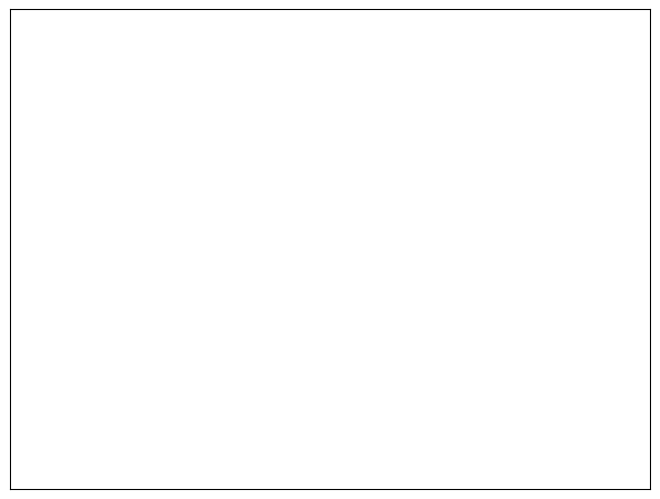